# Desafio

**Análise exploratória**

1 - Carregue os dados em um DataFrame pandas.    
2 - Analise e responda qual foi o crescimento das vendas (VendasSupermercados) dos últimos 12 meses (Set/2022 - Agosto 2023 vs Set/2021 - Agosto 2022)?    
3 - Analise e responda se existe sazonalidade e tendência nesses dados? Como você descreveria e mostraria graficamente?     
4 - Analise e responda se existe relação entre o CDI e as vendas? Como você a descreveria e mostraria graficamente? 
    
**Modelagem** 

1 - Usando uma biblioteca de sua escolha, treine um modelo de machine learning (multivariado) para prever as vendas de supermercados.
2 - Como você usou esses dados (vendas, cdi e datas) para criar variáveis?     
3 - Faça a modelagem numa estratégia de validação com 2 backtests. Calcule o MAPE (Mean absolute percentage error) 
    para cada um desses backtests e reporte a média dos MAPEs. Explique como definiu o tamanho do backtest 
    (por exemplo:3,6,12 ou 24 meses).
4- Faça a previsão dos próximos 12 meses e crie um gráfico de linhas (eixo X = date, eixo Y VendasSupermercados/Previsões)
    mostrando 1) os últimos 4 anos de histórico de vendas, 2) as projeções dos 2 backtests, 3) o ano projetado. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kendalltau

# Análise Exploratória do Dados

## Importamos os Dados

In [2]:
path_to_csv_file: str = "./VendasSupermercados+CDI.csv"

In [3]:
super_market_df: pd.DataFrame = pd.read_csv(
    filepath_or_buffer=path_to_csv_file,
    delimiter=";"
)

super_market_df.head()

,Date,VendasSupermercados,CDI
0,2010-01-01,76.39,0.66
1,2010-02-01,73.95,0.59
2,2010-03-01,81.69,0.76
3,2010-04-01,77.91,0.66
4,2010-05-01,78.66,0.75


## Verificamos Tipo de Dados

In [4]:
super_market_df.dtypes

Date                    object
VendasSupermercados    float64
CDI                    float64
dtype: object

*O campo Date deve ser convertido para o tipo data*

## Convertemos o Campos "DATE" para data

In [5]:
super_market_df["Date"]: pd.Series = pd.to_datetime(super_market_df["Date"])
super_market_df.dtypes

Date                   datetime64[ns]
VendasSupermercados           float64
CDI                           float64
dtype: object

## Verificamos Valores em Branco

In [6]:
super_market_df.isnull().sum()

Date                   0
VendasSupermercados    0
CDI                    0
dtype: int64

## Verificamos se Temos Datas Repetidas

In [7]:
super_market_df["Date"].value_counts()

Date
2010-01-01    1
2018-08-01    1
2018-10-01    1
2018-11-01    1
2018-12-01    1
             ..
2014-08-01    1
2014-09-01    1
2014-10-01    1
2014-11-01    1
2023-08-01    1
Name: count, Length: 164, dtype: int64

## Obtemos uma Visão Topológica das Variáveis

In [8]:
super_market_df.describe()

,Date,VendasSupermercados,CDI
count,164,164.000000,164.000000
mean,2016-10-15 19:19:01.463414528,93.174329,0.738537
min,2010-01-01 00:00:00,73.950000,0.130000
25%,2013-05-24 06:00:00,88.070000,0.537500
50%,2016-10-16 12:00:00,91.700000,0.785000
75%,2020-03-08 18:00:00,97.612500,0.952500
max,2023-08-01 00:00:00,122.750000,1.210000
std,NaN,9.001255,0.281626


*Observando os valores de VendasSupermercados podemos observar que iremos encontrar outliers que devem 
refletir no bloxplot.*

## Plotamos BoxPlots

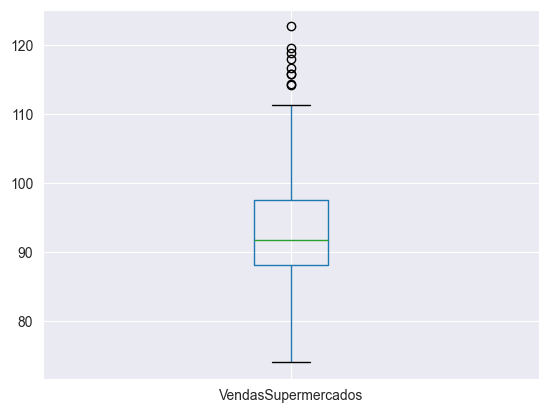

In [9]:
super_market_df.boxplot(
    column=[
        "VendasSupermercados"
    ]
)

plt.show()

*Ao analisar VendasSupermercados, observamos a presença de vários outliers. Contudo, é crucial consultar um especialista 
na área para determinar se esses resultados são inerentes ao problema em questão ou se podem ser considerados 
anomalias indesejáveis, como possíveis erros de digitação. A interpretação correta dos outliers dependerá do 
contexto específico do domínio, e a orientação de um especialista ajudará a tomar decisões informadas sobre 
como lidar com essas observações atípicas no contexto do modelo ou da análise de dados. Para este teste vamos
considerar que estes valores são inerentes ao problema e que não devem ser tratados. Inclusive essses valores podem
ser frutos de sazonalidade*

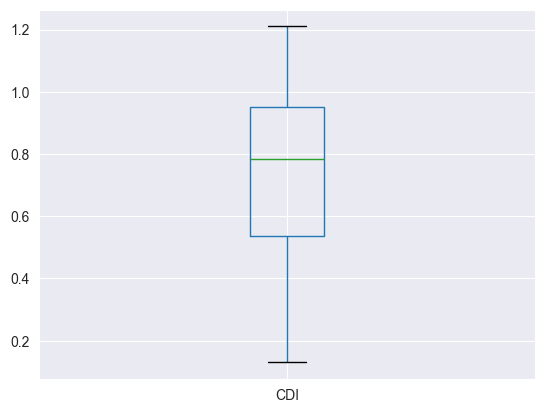

In [10]:
super_market_df.boxplot(
    column=[
        "CDI"
    ]
)

plt.show()

## Plotamos os Histogramas

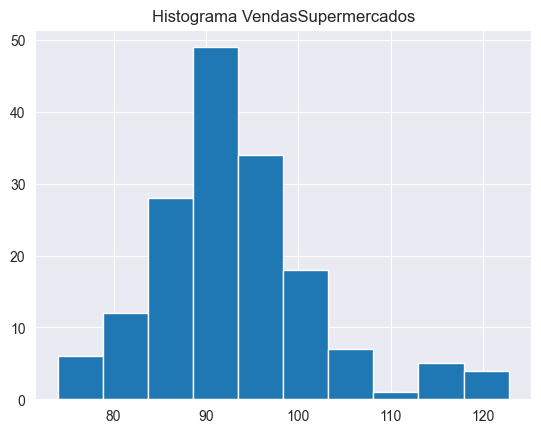

In [11]:
super_market_df["VendasSupermercados"].hist()
plt.title(label="Histograma VendasSupermercados")
plt.show()

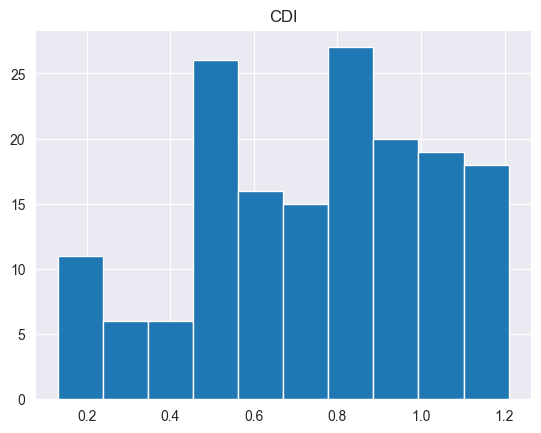

In [12]:
super_market_df["CDI"].hist()
plt.title(label="CDI")
plt.show()

## Verificamos Normalidade

Temos: n > 50

In [13]:
def check_data_normality(
        dataframe: pd.DataFrame,
        fields_list: list[str]
):
    for field in fields_list:
        print("------------------------------------------")
        print("Field", field)

        result_skewness = skew(super_market_df[field])

        print(f"Skewness: {result_skewness}")

        if result_skewness > 0:
            print("The distribution is positively skewed (long right tail).")
        elif result_skewness < 0:
            print("The distribution is negatively skewed (long left tail).")
        else:
            print("The distribution is symmetric.")

        result_kurtosis = kurtosis(super_market_df[field])

        print(f"Kurtosis: {result_kurtosis}")

        if result_kurtosis > 3:
            print("The distribution is leptokurtic (more peaks and heavier tails).")
        elif result_kurtosis < 3:
            print("The distribution is platykurtic (fewer peaks and lighter tails).")
        else:
            print("The distribution is normal (mesokurtic).")

In [14]:
check_data_normality(
    dataframe=super_market_df,
    fields_list=["VendasSupermercados", "CDI"]
)

------------------------------------------
Field VendasSupermercados
Skewness: 0.8223753759418065
The distribution is positively skewed (long right tail).
Kurtosis: 1.2214275839536084
The distribution is platykurtic (fewer peaks and lighter tails).
------------------------------------------
Field CDI
Skewness: -0.3561285798230702
The distribution is negatively skewed (long left tail).
Kurtosis: -0.7687677530263093
The distribution is platykurtic (fewer peaks and lighter tails).


## Verificamos Correlação

In [15]:
df_correlation: pd.DataFrame = super_market_df[
    [
        "Date",
        "VendasSupermercados",
        "CDI"
    ]
].corr()

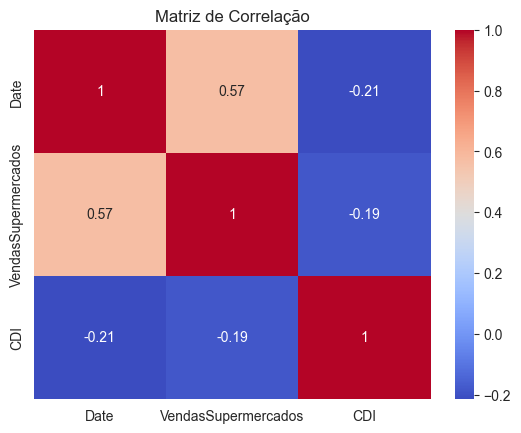

In [16]:
sns.heatmap(
    data=df_correlation,
    annot=True,
    cmap="coolwarm"
)
plt.title(label="Matriz de Correlação")
plt.show()

Podemos observar correlação:
 
Moderadamente forte, entre: 
    1 - Date x VendasSupermercados 
    
Fraca, entre:
    1 - Date x CDI
    2 - CDI x VendasSupermercados

## Análise de Tendência

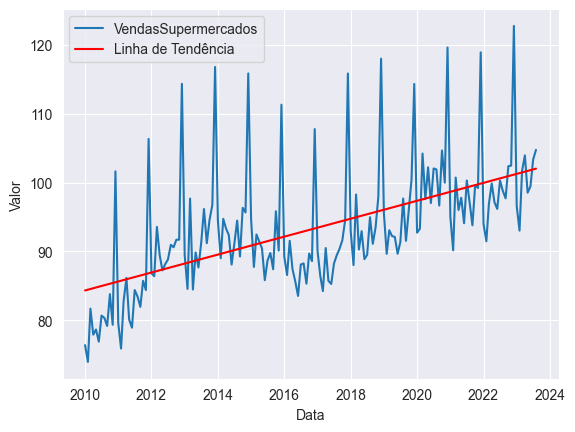

In [17]:
x_values: np.ndarray = np.arange(len(super_market_df["Date"]))
y_values: pd.Series = super_market_df["VendasSupermercados"]

coefficients: np.ndarray = np.polyfit(
    x=x_values,
    y=y_values,
    deg=1
)

trend_line: np.ndarray = np.polyval(
    p=coefficients,
    x=x_values
)

plt.plot(
    super_market_df["Date"],
    super_market_df["VendasSupermercados"],
    label="VendasSupermercados"
)

plt.plot(
    super_market_df["Date"],
    trend_line,
    color="red",
    label="Linha de Tendência"
)

plt.xlabel(xlabel="Data")
plt.ylabel(ylabel="Valor")
plt.legend()
plt.show()

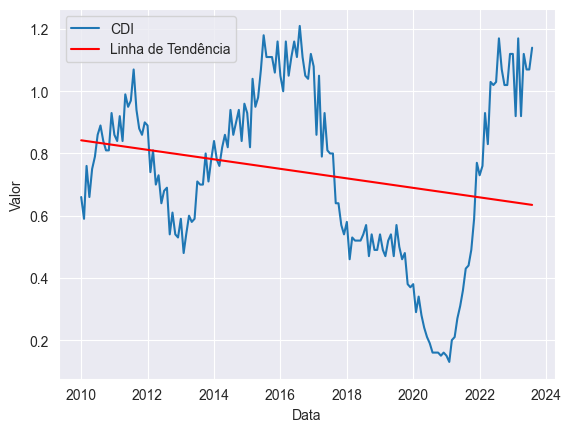

In [18]:
x_values: np.ndarray = np.arange(len(super_market_df["Date"]))
y_values: pd.Series = super_market_df["CDI"]

coefficients: np.ndarray = np.polyfit(
    x=x_values,
    y=y_values,
    deg=1
)

trend_line: np.ndarray = np.polyval(
    p=coefficients,
    x=x_values
)

plt.plot(
    super_market_df["Date"],
    super_market_df["CDI"],
    label="CDI"
)

plt.plot(
    super_market_df["Date"],
    trend_line,
    color="red",
    label="Linha de Tendência"
)

plt.xlabel(xlabel="Data")
plt.ylabel(ylabel="Valor")
plt.legend()
plt.show()

In [19]:
def check_data_trend(
        dataframe: pd.DataFrame,
        fields_name_list: list[str]
):
    for field in fields_name_list:        
        print("--------------------------------------")
        print("Field: ", field)
    
        tau, p_value = kendalltau(super_market_df[field], range(len(super_market_df)))
        print(f'Test Statistic (Tau): {tau}\nP-Value: {p_value}')
        
        if p_value <= 0.05:
            print('Há evidências estatísticas de uma tendência.')
        else:
            print('Não há evidências estatísticas de uma tendência significativa.')


In [20]:
check_data_trend(
    dataframe=super_market_df,
    fields_name_list=["VendasSupermercados", "CDI"]
)

--------------------------------------
Field:  VendasSupermercados
Test Statistic (Tau): 0.4952096307783412
P-Value: 5.054723434674881e-21
Há evidências estatísticas de uma tendência.
--------------------------------------
Field:  CDI
Test Statistic (Tau): -0.13218143374987404
P-Value: 0.012549021054553692
Há evidências estatísticas de uma tendência.


## Verificamos Crescimento Entre Períodos

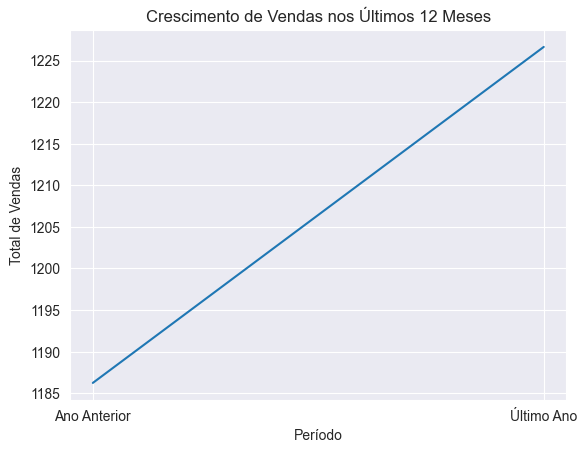

Taxa de Crescimento: 3.41%


In [21]:
last_year_data: pd.DataFrame = super_market_df[
    (super_market_df["Date"] >= "2022-09-01")
    &
    (super_market_df["Date"] <= "2023-08-31")
    ]

previous_year_data: pd.DataFrame = super_market_df[
    (super_market_df["Date"] >= "2021-09-01")
    &
    (super_market_df["Date"] <= "2022-08-31")
    ]

last_year_sales: float = last_year_data["VendasSupermercados"].sum()
previous_year_sales: float = previous_year_data["VendasSupermercados"].sum()

growth_rate: float = ((last_year_sales - previous_year_sales) / previous_year_sales) * 100

plt.plot(
    ["Ano Anterior", "Último Ano"],
    [previous_year_sales, last_year_sales]
)

plt.xlabel(xlabel="Período")
plt.ylabel(ylabel="Total de Vendas")
plt.title(label="Crescimento de Vendas nos Últimos 12 Meses")
plt.grid(visible=True)
plt.show()

print(f"Taxa de Crescimento: {growth_rate:.2f}%")

Podemos observar que a taxa de crescimento entre os períodos solicitados foi de ≈3.41%

## Realizando Decomposição Temporal

In [23]:
decompose_df: pd.DataFrame = super_market_df.copy()

super_market_df["Date"]: pd.Series = pd.to_datetime(
    arg=super_market_df["Date"]
)

super_market_df.set_index(
    keys="Date",
    inplace=True
)

result: DecomposeResult = seasonal_decompose(
    x=super_market_df["VendasSupermercados"],
    model="additive",
    period=12
)

anos: np.ndarray = pd.to_datetime(super_market_df.index).to_period("Y").astype(str).unique()

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(
    super_market_df["VendasSupermercados"],
    label="Original"
)
plt.legend()
plt.xticks(
    ticks=anos,
    rotation=45,
    ha="right"
)

plt.subplot(4, 1, 2)
plt.plot(
    result.trend,
    label="Tendência"
)
plt.legend()
plt.xticks(
    ticks=anos,
    rotation=45,
    ha="right"
)

plt.subplot(4, 1, 3)
plt.plot(
    result.seasonal,
    label="Sazonalidade"
)
plt.legend()
plt.xticks(
    ticks=anos,
    rotation=45,
    ha="right"
)

plt.subplot(4, 1, 4)
plt.plot(
    result.resid,
    label="Resíduos"
)
plt.legend()
plt.xticks(
    ticks=anos,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.show()


KeyError: 'Date'